# Sentiment Classification and Topic Modeling of Women's Clothing Reviews Using TF-IDF, Logistic Regression, and LDA

## GitHub Repository

You can view the full code and results at:

https://github.com/Randalburks/CMSE802_Project.git

## Project Purpose

This project aims to analyze and interpret customer sentiment from a women’s clothing e-commerce review dataset. While product ratings provide a numeric summary of customer satisfaction, they often overlook the nuanced feedback shared through written reviews. By leveraging sentiment classification, clustering, and topic modeling techniques, this project explores how textual sentiment aligns with numeric ratings and what deeper insights can be drawn from review content.

## Objectives

The primary objective is to classify customer sentiment—Positive, Neutral, or Negative—based on the written content of reviews using supervised machine learning methods. In addition, the project compares rating-based sentiment with text-derived sentiment to detect any inconsistencies or hidden dissatisfaction. It segments customers through clustering techniques to identify distinct reviewer groups, and it applies topic modeling to discover common themes within review text. The project also seeks to determine which clothing product categories receive the highest or lowest sentiment. Finally, it evaluates model performance using metrics such as accuracy, precision, recall, and F1-score while presenting insights through a series of well-designed visualizations.


## Visuals Included

- Sentiment Distribution  
- PCA Cluster Visualization  
- Text Sentiment vs Star Rating  
- Review Length by Sentiment Category  
- Sentiment by Clothing Class, Influence Level, and Age Group  
- Topic Modeling Summary


### Handling Missing Reviews
Drops rows with missing review text to ensure only valid entries are used for analysis.

In [3]:
def preprocess_reviews(df):
    df = df.dropna(subset=["Review Text"])
    df["Sentiment"] = df["Rating"].apply(lambda x: "Positive" if x >= 4 else ("Neutral" if x == 3 else "Negative"))
    return df

def balance_classes(train_df):
    pos = train_df[train_df.label == "Positive"]
    neu = train_df[train_df.label == "Neutral"]
    neg = train_df[train_df.label == "Negative"]
    neu_upsampled = resample(neu, replace=True, n_samples=len(pos), random_state=42)
    neg_upsampled = resample(neg, replace=True, n_samples=len(pos), random_state=42)
    return pd.concat([pos, neu_upsampled, neg_upsampled])

def train_logistic_regression(X_train, y_train):
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))


# Importing the Libraries

### Data Loading and Libraries
This section loads the required libraries for data processing, visualization, and modeling.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/randalburks/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# EDA

### Dataset Import
Reads the women's clothing reviews dataset into a pandas DataFrame.

In [9]:
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv") 

### Sentiment Labeling
Converts numeric star ratings into sentiment categories: Positive, Neutral, or Negative.

In [11]:
# Create Sentiment column if it doesn't exist yet
df["Sentiment"] = df["Rating"].apply(lambda x: "Positive" if x >= 4 else ("Neutral" if x == 3 else "Negative"))

X_train, X_test, y_train, y_test = train_test_split(
    df["Review Text"], df["Sentiment"], test_size=0.2, random_state=42)

### Handling Missing Reviews
Drops rows with missing review text to ensure only valid entries are used for analysis.

In [13]:
df = df.dropna(subset=["Review Text"])

df["Sentiment"] = df["Rating"].apply(lambda x: "Positive" if x >= 4 else ("Neutral" if x == 3 else "Negative"))

X_train, X_test, y_train, y_test = train_test_split(
    df["Review Text"], df["Sentiment"], test_size=0.2, random_state=42)

In [14]:

print("Final shape after dropping missing reviews:", df.shape)
print("\nMissing values (should be minimal now):")
print(df.isnull().sum())

Final shape after dropping missing reviews: (22641, 12)

Missing values (should be minimal now):
Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      2966
Review Text                   0
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                13
Department Name              13
Class Name                   13
Sentiment                     0
dtype: int64


In [15]:
print("\nSample of cleaned dataset:")
display(df[['Rating', 'Review Text', 'Sentiment']].head())


Sample of cleaned dataset:


,Rating,Review Text,Sentiment
0,4,Absolutely wonderful - silky and sexy and comf...,Positive
1,5,Love this dress! it's sooo pretty. i happene...,Positive
2,3,I had such high hopes for this dress and reall...,Neutral
3,5,"I love, love, love this jumpsuit. it's fun, fl...",Positive
4,5,This shirt is very flattering to all due to th...,Positive


In [16]:
print("\nSentiment distribution:")
print(df['Sentiment'].value_counts())


Sentiment distribution:
Sentiment
Positive    17448
Neutral      2823
Negative     2370
Name: count, dtype: int64


In [17]:
df['Review Length'] = df['Review Text'].apply(lambda x: len(x.split()))
print("\nReview Length summary:")
print(df['Review Length'].describe())


Review Length summary:
count    22641.000000
mean        60.196679
std         28.534612
min          2.000000
25%         36.000000
50%         59.000000
75%         88.000000
max        115.000000
Name: Review Length, dtype: float64


### Handling Missing Reviews
Drops rows with missing review text to ensure only valid entries are used for analysis.

In [19]:
#TF-IDF vectorization

df = df.dropna(subset=["Review Text"])

# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(
    df["Review Text"], df["Sentiment"], test_size=0.2, random_state=42)

# TF-IDF vectorization
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [20]:
# Training Naive Bayes Classifier
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred = nb.predict(X_test_tfidf)


### Handling Missing Reviews
Drops rows with missing review text to ensure only valid entries are used for analysis.

In [22]:
df = df.dropna(subset=["Review Text"])

# Creating sentiment labels
df["Sentiment"] = df["Rating"].apply(lambda x: "Positive" if x >= 4 else ("Neutral" if x == 3 else "Negative"))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df["Review Text"], df["Sentiment"], test_size=0.2, random_state=42)

# Creating train DataFrame
train_df = pd.DataFrame({'text': X_train, 'label': y_train})

# Upsample Neutral and Negative
pos = train_df[train_df.label == "Positive"]
neu = train_df[train_df.label == "Neutral"]
neg = train_df[train_df.label == "Negative"]
neu_upsampled = resample(neu, replace=True, n_samples=len(pos), random_state=42)
neg_upsampled = resample(neg, replace=True, n_samples=len(pos), random_state=42)
train_balanced = pd.concat([pos, neu_upsampled, neg_upsampled])

# TF-IDF with bigrams
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words="english", max_features=8000)
X_train_bal = tfidf.fit_transform(train_balanced['text'])
y_train_bal = train_balanced['label']
X_test_tfidf = tfidf.transform(X_test)

# Train and evaluate Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_bal, y_train_bal)
y_pred = lr.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Logistic Regression Accuracy: 0.7820710973724884

Classification Report:

              precision    recall  f1-score   support

    Negative       0.44      0.58      0.50       457
     Neutral       0.34      0.39      0.36       588
    Positive       0.94      0.88      0.91      3484

    accuracy                           0.78      4529
   macro avg       0.57      0.61      0.59      4529
weighted avg       0.81      0.78      0.79      4529



In [23]:
# K Means Clustering
# Selection and cleaning of clustering features
clust_df = df[['Age', 'Rating', 'Recommended IND']].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(clust_df)

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
df['Cluster'] = np.nan
df.loc[clust_df.index, 'Cluster'] = cluster_labels


In [24]:
sil_score = silhouette_score(X_scaled, cluster_labels)
db_score = davies_bouldin_score(X_scaled, cluster_labels)

print(f"\nK-Means Clustering Results (k={k})")
print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies-Bouldin Index: {db_score:.3f}")


K-Means Clustering Results (k=3)
Silhouette Score: 0.486
Davies-Bouldin Index: 0.737


In [25]:
# Average Characteristics of each customer cluster from K-means clustering analysis 

df['Cluster'] = df['Cluster'].astype(int)
cluster_summary = df.groupby('Cluster')[['Age', 'Rating', 'Recommended IND']].mean().round(2)
print(cluster_summary)


           Age  Rating  Recommended IND
Cluster                                
0        42.35    2.29              0.0
1        35.60    4.60              1.0
2        56.93    4.61              1.0


In [26]:
# Add number of words in each review
df['Review Length'] = df['Review Text'].apply(lambda x: len(x.split()))
# Creating VADER analyzer
sia = SentimentIntensityAnalyzer()
df['Text Sentiment Score'] = df['Review Text'].apply(lambda x: sia.polarity_scores(x)['compound'])


In [27]:
def compare_sentiment(row):
    if row['Sentiment'] == "Positive" and row['Text Sentiment Score'] < 0:
        return "Mismatch: Positive Rating, Negative Text"
    elif row['Sentiment'] == "Negative" and row['Text Sentiment Score'] > 0:
        return "Mismatch: Negative Rating, Positive Text"
    else:
        return "Aligned"

df['Sentiment Alignment'] = df.apply(compare_sentiment, axis=1)


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.95, min_df=5, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['Review Text'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(doc_term_matrix)

terms = vectorizer.get_feature_names_out()

# Calculate quantile bins manually
quantiles = df['Positive Feedback Count'].quantile([0, 1/3, 2/3, 1]).unique()

# Adjust number of labels to match available bins
label_sets = {
    4: ['Low', 'Medium', 'High'],
    3: ['Low', 'High'],
    2: ['All']
}
num_bins = len(quantiles)
labels = label_sets.get(num_bins, [f'Group {i}' for i in range(num_bins - 1)])

# Apply qcut with valid bin count
df['Influence Level'] = pd.qcut(
    df['Positive Feedback Count'],
    q=len(labels),
    labels=labels,
    duplicates='drop'
)

# Average sentiment for most-loved products
top_product_sentiment = df.groupby('Clothing ID')['Text Sentiment Score'].mean().sort_values(ascending=False).head(10)

# Average sentiment by product category
class_sentiment = df.groupby('Class Name')['Text Sentiment Score'].mean().sort_values(ascending=False)


sia = SentimentIntensityAnalyzer()
df['Text Sentiment Score'] = df['Review Text'].apply(lambda x: sia.polarity_scores(x)['compound'])


# Graphs/Results 

### Topic Modeling Insights

This topic modeling output highlights the main themes in customer reviews. The topics reveal frequent mentions of **fit and size** (e.g., "xs", "medium", "small"), **specific clothing types** (e.g., "shirt", "dress", "jeans"), and **positive attributes** (e.g., "comfortable", "flattering", "beautiful"). Overall, customers focus on how the clothing fits, how it looks, and how it feels.


In [30]:
for idx, topic in enumerate(lda.components_):
    top_terms = [terms[i] for i in topic.argsort()[-10:]]
    print(f"\nTopic {idx+1}: {', '.join(top_terms)}")


Topic 1: usually, fit, wear, xs, medium, large, ordered, color, small, size

Topic 2: shirt, short, waist, little, fit, really, look, fabric, just, like

Topic 3: color, flattering, sweater, soft, comfortable, perfect, dress, wear, great, love

Topic 4: color, like, bought, wear, great, size, love, jeans, pants, fit

Topic 5: small, ordered, beautiful, fabric, like, just, love, fit, size, dress


### Average Sentiment Score by Product Class

This bar chart displays the average text-based sentiment score for each clothing class. Product types like **Chemises, Skirts, and Pants** received the highest average sentiment, indicating strong customer satisfaction. On the other hand, items such as **Casual bottoms and Trend** had lower average sentiment, suggesting areas where customer experience may need improvement. This visualization helps identify which product categories are performing well and which may require closer review.


/var/folders/j9/y9drl51s2gvbm203cbmk7py80000gn/T/ipykernel_930/3672189781.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_sentiment.values, y=class_sentiment.index, palette='coolwarm')


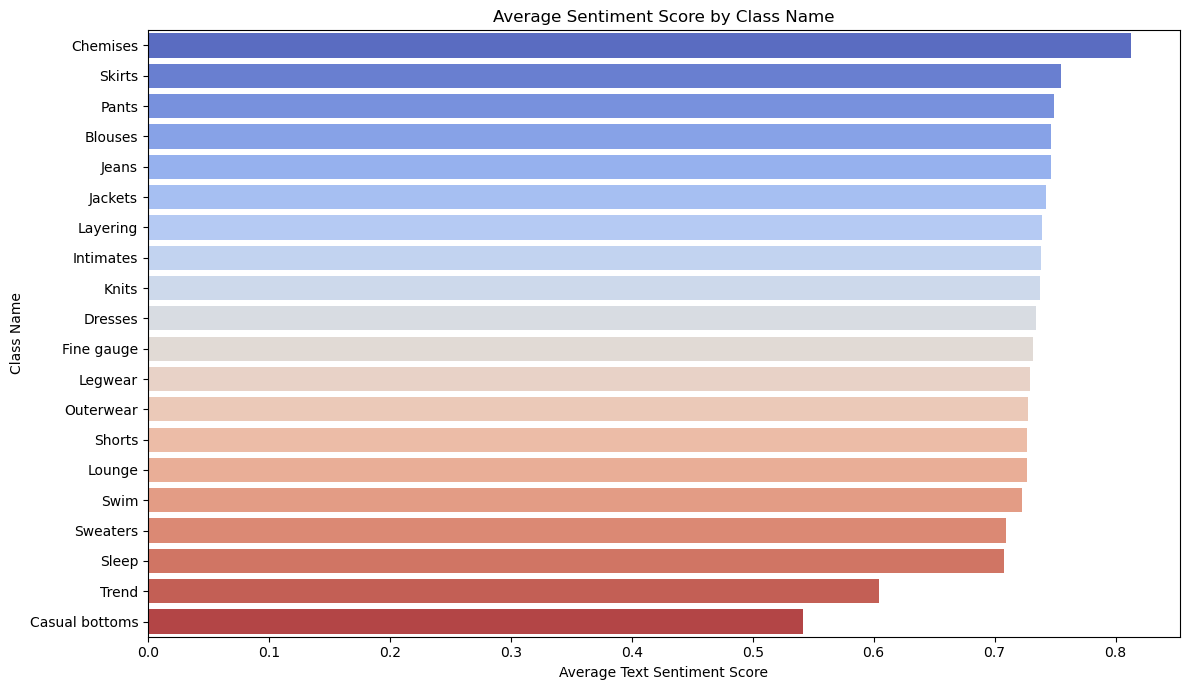

In [32]:
# 2. Bar chart: Sentiment by Class Name
class_sentiment = df.groupby('Class Name')['Text Sentiment Score'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 7))
sns.barplot(x=class_sentiment.values, y=class_sentiment.index, palette='coolwarm')
plt.title("Average Sentiment Score by Class Name")
plt.xlabel("Average Text Sentiment Score")
plt.ylabel("Class Name")
plt.tight_layout()
plt.show()

### Sentiment Distribution

This bar chart shows the number of reviews in each sentiment category: Positive, Neutral, and Negative. The majority of reviews are **positive**, indicating high overall customer satisfaction. However, the smaller proportion of **neutral and negative** reviews suggests the need to explore product or experience-related concerns within those segments.


### Sentiment Distribution
Visualizes the count of each sentiment class to assess balance in the dataset.

/var/folders/j9/y9drl51s2gvbm203cbmk7py80000gn/T/ipykernel_930/4194595077.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Sentiment", palette="Set2")


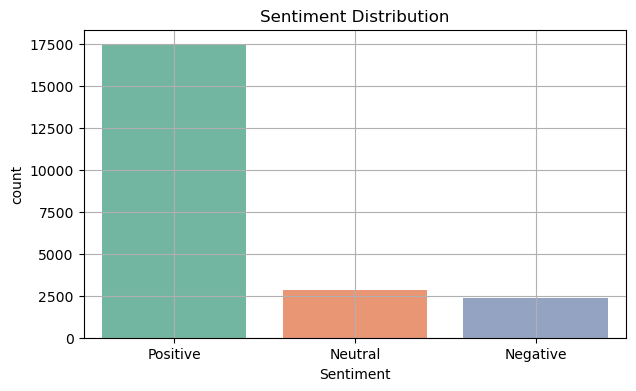

In [35]:
# Sentiment Distribution
plt.figure(figsize=(7, 4))
sns.countplot(data=df, x="Sentiment", palette="Set2")
plt.title("Sentiment Distribution")
plt.grid(True)
plt.show()

### Age Distribution by Cluster

This boxplot shows the age distribution of reviewers within each customer cluster. Cluster 1 contains the youngest group, Cluster 2 represents the oldest segment, and Cluster 0 includes a mid-range age group. These differences suggest that customer preferences and feedback patterns may vary by age group, which can be useful for targeted marketing or product recommendations.


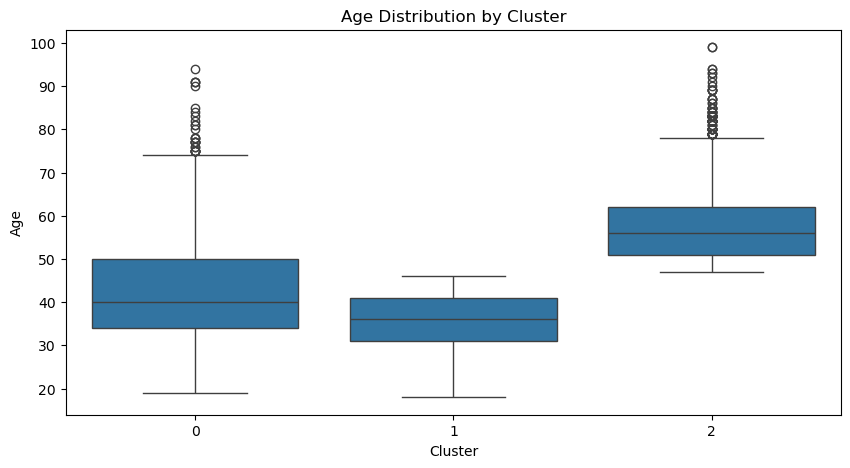

In [37]:
#Age and Rating Distribution by Cluster
plt.figure(figsize=(10, 5))
sns.boxplot(x='Cluster', y='Age', data=df)
plt.title('Age Distribution by Cluster')
plt.show()

### Average Sentiment Score by Cluster

This bar chart compares the average sentiment score across customer clusters. Cluster 1 and Cluster 2 show **high average sentiment scores**, indicating generally positive experiences. In contrast, Cluster 0 has a **significantly lower average sentiment**, suggesting this group had more negative or neutral feedback. This difference highlights how customer satisfaction varies by segment and may inform targeted improvements.


/var/folders/j9/y9drl51s2gvbm203cbmk7py80000gn/T/ipykernel_930/681345616.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_sentiment.index, y=cluster_sentiment.values, palette='crest')


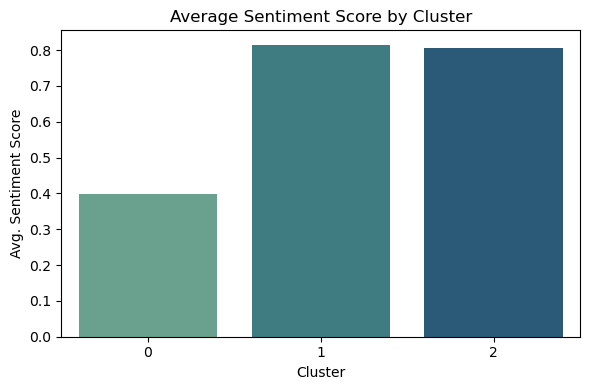

In [39]:
if 'Cluster' in df.columns:
    cluster_sentiment = df.groupby('Cluster')['Text Sentiment Score'].mean()
    plt.figure(figsize=(6, 4))
    sns.barplot(x=cluster_sentiment.index, y=cluster_sentiment.values, palette='crest')
    plt.title("Average Sentiment Score by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Avg. Sentiment Score")
    plt.tight_layout()
    plt.show()

### Rating Distribution by Cluster

This boxplot shows how customer star ratings are distributed across different clusters. Clusters 1 and 2 mostly gave **high ratings (4–5 stars)**, while Cluster 0 had a much **lower median rating** with more spread and outliers. This reinforces earlier sentiment analysis, indicating that Cluster 0 represents less satisfied customers.


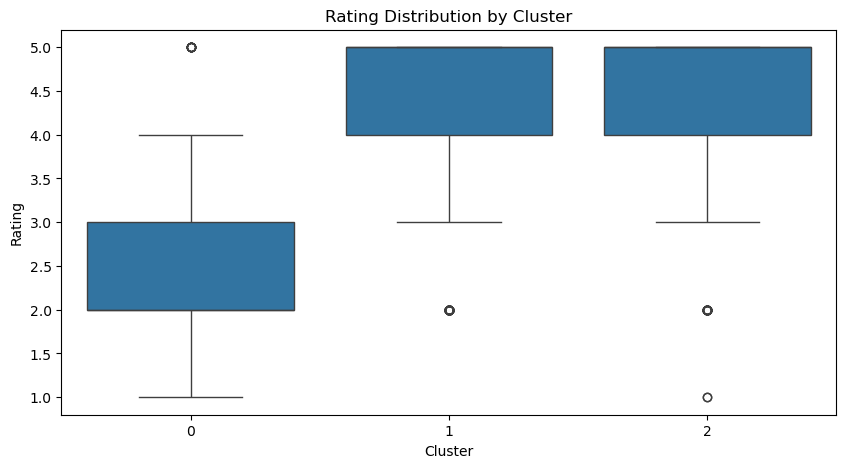

In [41]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Cluster', y='Rating', data=df)
plt.title('Rating Distribution by Cluster')
plt.show()

### Department Breakdown by Cluster

This stacked bar chart displays the distribution of department categories across each customer cluster. Cluster 1 has the **highest number of reviews**, particularly from the **Tops** and **Dresses** departments. Cluster 2 is also dominated by **Tops**, while Cluster 0 has fewer reviews overall. The chart reveals which product types are most frequently reviewed within each cluster, offering insight into category preferences across customer segments.


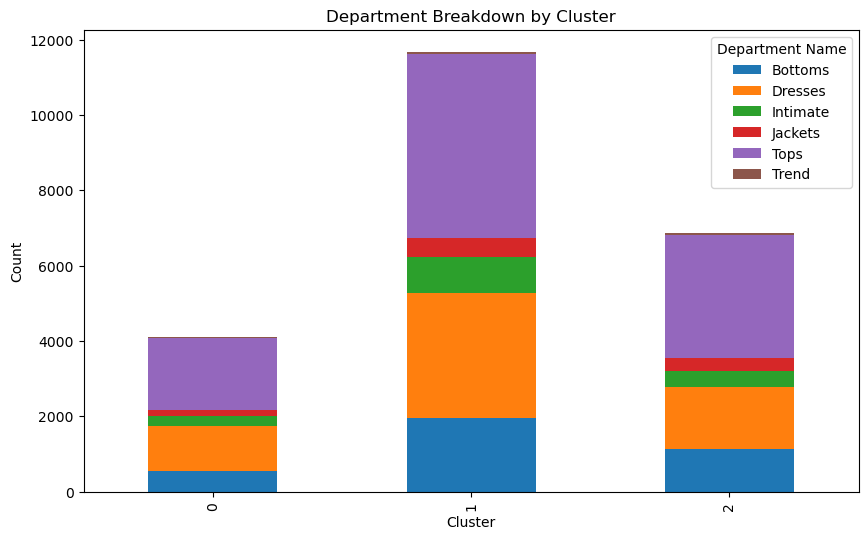

In [43]:
#Department Breakdown by Cluster
pd.crosstab(df['Cluster'], df['Department Name']).plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Department Breakdown by Cluster')
plt.ylabel('Count')
plt.show()


### PCA of Customers Colored by Cluster

This scatter plot visualizes customer clusters using PCA for dimensionality reduction. Each point represents a customer, and the colors indicate cluster membership. The clear separation between clusters in PCA space shows that the features used for clustering successfully grouped customers with similar behaviors or attributes. This validates the effectiveness of the clustering step.


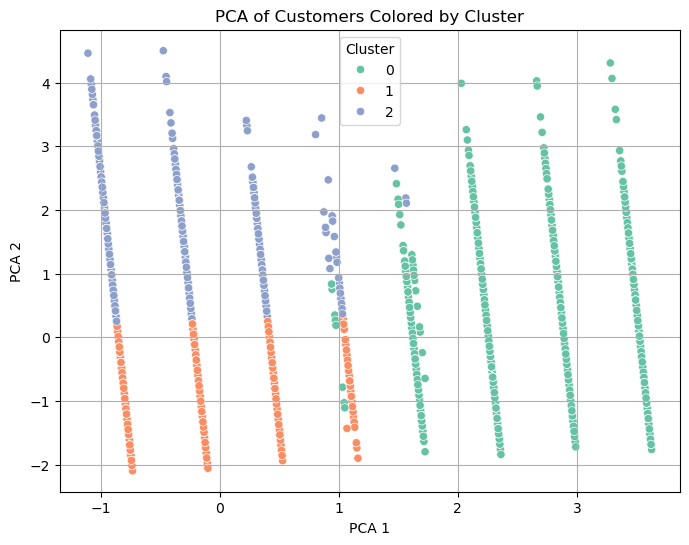

In [45]:
# Apply PCA to standardized features
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Storing PCA results
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

# clusters using PCA-reduced features
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue=df['Cluster'], palette='Set2', data=df)
plt.title('PCA of Customers Colored by Cluster')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

### Sentiment Distribution by Cluster

This stacked bar chart shows the proportion of positive, neutral, and negative reviews within each customer cluster. Cluster 0 has the largest share of negative and neutral reviews, while Clusters 1 and 2 are dominated by positive sentiment. This shows meaningful differences in sentiment profiles between clusters, which can inform targeted product strategies or customer engagement approaches.


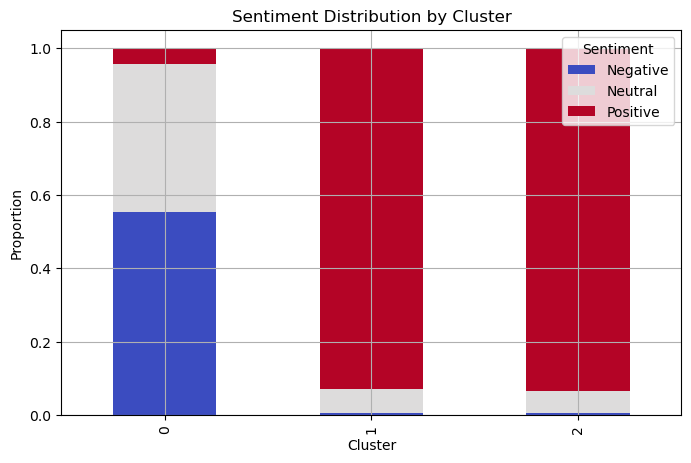

In [47]:
# Sentiment Behavior breakdown per cluster
if 'Sentiment' in df.columns:
    sentiment_by_cluster = df.groupby('Cluster')['Sentiment'].value_counts(normalize=True).unstack().fillna(0)
    sentiment_by_cluster.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(8, 5))
    plt.title("Sentiment Distribution by Cluster")
    plt.ylabel("Proportion")
    plt.xlabel("Cluster")
    plt.legend(title="Sentiment")
    plt.grid(True)
    plt.show()
